<h1>SCA representing traces as RPs using neural networks</h1>

In [45]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.optim as optim
from pyts.image import RecurrencePlot
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
from torchinfo import summary
from torchvision import transforms

<h3>Load the data</h3>

In [46]:
filename = './dataset/ASCAD.h5'

In [47]:
def load_ascad(file_path):
    with h5py.File(file_path, 'r') as f:
        X_profiling = np.array(f['Profiling_traces/traces'])
        Y_profiling = np.array(f['Profiling_traces/labels'])
        X_attack = np.array(f['Attack_traces/traces'])
        Y_attack = np.array(f['Attack_traces/labels'])
        
        metadata_attack = f['Attack_traces/metadata']
        plaintexts_attack = np.array(metadata_attack['plaintext'])
        key = np.array(metadata_attack['key'])
    
    return (X_profiling, Y_profiling), (X_attack, Y_attack), plaintexts_attack, key

<h3>Visualize the data</h3>

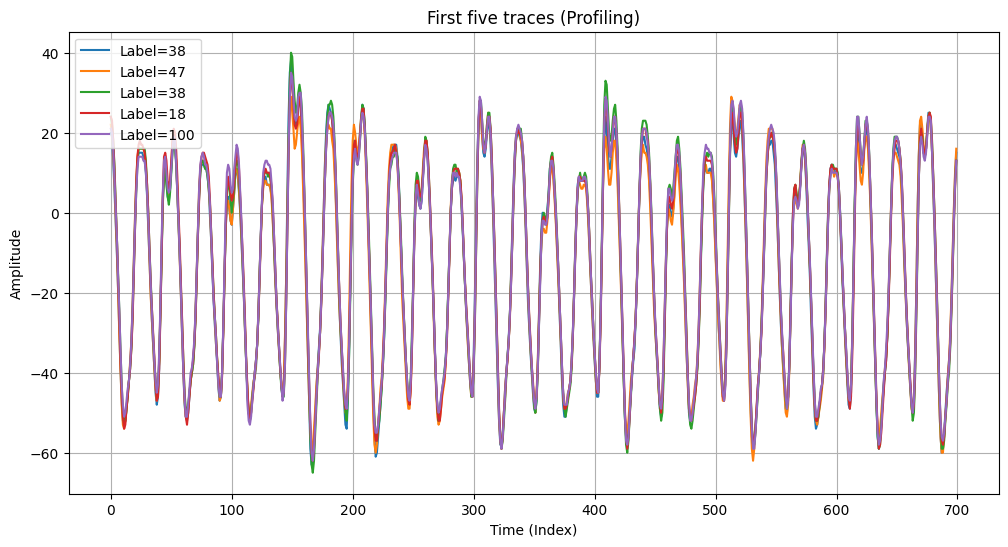

In [48]:
(X_profiling, Y_profiling), (X_attack, Y_attack), plaintexts_attack, key = load_ascad(filename)
X_train, X_val, Y_train, Y_val = train_test_split(X_profiling, Y_profiling, test_size=0.1, random_state=42)

num_traces_to_plot = 5

plt.figure(figsize=(12, 6))
for i in range(num_traces_to_plot):
    plt.plot(X_profiling[i], label=f"Label={Y_profiling[i]}")

plt.title("First five traces (Profiling)")
plt.xlabel("Time (Index)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

<h3>Split data into trainig, validation and test</h3>

In [49]:
(X_profiling, Y_profiling), (X_attack, Y_attack), plaintexts_attack, key = load_ascad(filename)
X_train, X_val, Y_train, Y_val = train_test_split(X_profiling, Y_profiling, test_size=0.1, random_state=42)
print("Trazas de entrenamiento:", X_train.shape)
print("Etiquetas de entrenamiento:", Y_train.shape)
print("Trazas de validación:", X_val.shape)
print("Etiquetas de validación:", Y_val.shape)
print("Trazas de ataque:", X_attack.shape)
print("Etiquetas de ataque:", Y_attack.shape)   

Trazas de entrenamiento: (45000, 700)
Etiquetas de entrenamiento: (45000,)
Trazas de validación: (5000, 700)
Etiquetas de validación: (5000,)
Trazas de ataque: (10000, 700)
Etiquetas de ataque: (10000,)


<h3>Time series Encoder</h3>

In [50]:
class RPTimeSeriesDataset(Dataset):
    def __init__(self, X, y, rp_model=None):
        self.X = X
        self.y = y
        self.rp = rp_model or RecurrencePlot(threshold='point', percentage=20)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        series = self.X[idx].reshape(1, -1)
        rp = self.rp.fit_transform(series)[0]
        rp = np.expand_dims(rp, axis=0)
        return torch.tensor(rp, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

<h3>Encode time series into RPs</h3>

In [51]:
train_dataset = RPTimeSeriesDataset(X_train, Y_train)
val_dataset = RPTimeSeriesDataset(X_val, Y_val)
test_dataset = RPTimeSeriesDataset(X_attack, Y_attack)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Text(0.5, 0.98, 'Recurrence Plots of First 6 Training Traces')

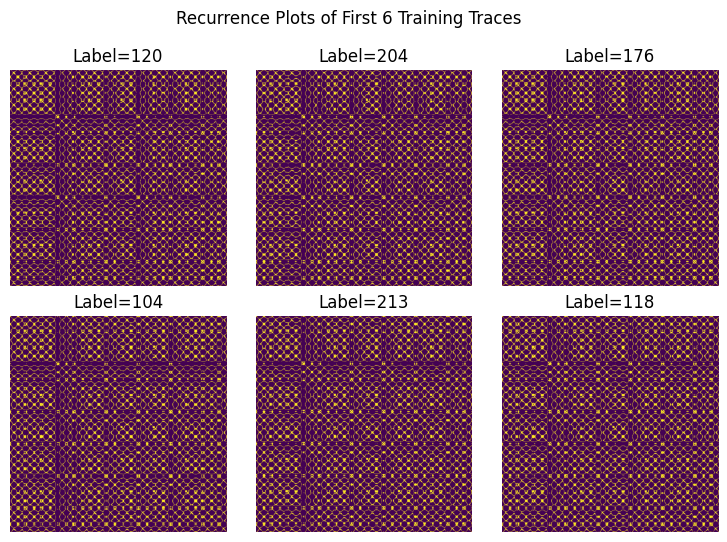

In [52]:
fig = plt.figure(figsize=(12, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 3), axes_pad=0.3)
for i in range(6):
    series = X_train[i].reshape(1, -1)
    rp = RecurrencePlot(threshold='point', percentage=20).fit_transform(series)[0]
    grid[i].imshow(rp)
    grid[i].set_title(f"Label={Y_train[i]}")
    grid[i].axis('off')
plt.suptitle("Recurrence Plots of First 6 Training Traces")

<h3>Build base model</h3>

In [53]:
class CNN(nn.Module):
    def __init__(self, num_classes=256):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.5)

        self.flatten_size = 16 * 175 * 175

        self.fc1 = nn.Linear(self.flatten_size, 250)
        self.bn3 = nn.BatchNorm1d(250)
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(250, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.bn3(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = CNN(num_classes=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

summary(model)

Using device: cuda


Layer (type:depth-idx)                   Param #
CNN                                      --
├─Conv2d: 1-1                            208
├─BatchNorm2d: 1-2                       16
├─MaxPool2d: 1-3                         --
├─Dropout: 1-4                           --
├─Conv2d: 1-5                            1,168
├─BatchNorm2d: 1-6                       32
├─MaxPool2d: 1-7                         --
├─Dropout: 1-8                           --
├─Linear: 1-9                            122,500,250
├─BatchNorm1d: 1-10                      500
├─Dropout: 1-11                          --
├─Linear: 1-12                           64,256
Total params: 122,566,430
Trainable params: 122,566,430
Non-trainable params: 0

In [54]:
for epoch in range(10):
    print(f"\nEpoch {epoch+1}")
    
    model.train()
    running_loss = 0
    train_bar = tqdm(train_loader, desc="Training", leave=False)
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    model.eval()    
    val_loss = 0
    correct = 0
    total = 0
    val_bar = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_bar.set_postfix(loss=loss.item())

    acc = correct / total
    print(f"Train Loss: {running_loss / len(train_loader):.4f} | Val Loss: {val_loss / len(val_loader):.4f} | Val Acc: {acc:.4f}")


Epoch 1


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "models/ascad_model2D_1.pt")

<h3>Evaluate model performance</h3>

In [ ]:
AES_SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5,
    0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0,
    0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc,
    0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a,
    0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0,
    0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
    0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85,
    0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5,
    0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17,
    0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88,
    0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c,
    0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9,
    0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6,
    0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e,
    0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94,
    0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68,
    0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

def compute_rank(predictions, plaintexts, real_key_byte, sbox):
    n_traces = predictions.shape[0]
    ranks = np.zeros(n_traces)

    key_bytes = range(256)
    scores = np.zeros(256)

    for trace_idx in range(n_traces):
        pt_byte = plaintexts[trace_idx]
        for k in key_bytes:
            sbox_out = sbox[pt_byte ^ k]
            prob = predictions[trace_idx, sbox_out]
            scores[k] += np.log(prob + 1e-36)  # evitar log(0)
        
        # Ordenar puntajes (descendiente), obtener posición de la llave correcta
        sorted_indices = np.argsort(scores)[::-1]
        rank = np.where(sorted_indices == real_key_byte)[0][0]
        ranks[trace_idx] = rank
    
    return ranks

In [ ]:
model = CNN(num_classes=256).to(device)
model.load_state_dict(torch.load("models/ascad_model2D_1.pt"))
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x.to(device))
        probs = torch.nn.functional.softmax(outputs, dim=1)
        all_preds.append(probs.cpu().numpy())
        all_labels.append(batch_y.numpy())

predictions = np.concatenate(all_preds, axis=0)
labels = np.concatenate(all_labels, axis=0)

ge = compute_rank(predictions, plaintexts_attack, key[0], AES_SBOX)
plt.plot(ge)
plt.xlabel("Número de trazas")
plt.ylabel("Key Rank")
plt.title("Key Rank Guessing Entropy")
plt.grid()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x980000 and 2048x128)